# Medical Visual Question Answering (Med-VQA) on PathVQA Dataset

This notebook implements and compares two Med-VQA models:
1. **CNN-Based Baseline**: ResNet-50 + LSTM
2. **Vision-Language Model (VLM)**: ViT + BERT with Cross-Attention

## Table of Contents
1. Setup and Imports
2. Dataset Loading
3. Data Preprocessing
4. Model 1: CNN-Based Baseline
5. Model 2: Vision-Language Model
6. Training Procedures
7. Evaluation Metrics
8. Results and Visualization

## 1. Setup and Imports

In [1]:
# Install required packages
!pip install datasets transformers torch torchvision pillow matplotlib scikit-learn tqdm -q

In [2]:
import os
import re
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from typing import Dict, List, Tuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

from transformers import (
    BertTokenizer, BertModel,
    ViTModel, ViTImageProcessor,
    AutoTokenizer
)

from datasets import load_dataset
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/home/yhgooi/Desktop/Machine Learning/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## 2. Dataset Loading

In [3]:
# Load PathVQA dataset from Hugging Face
print("Loading PathVQA dataset...")
dataset = load_dataset("flaviagiammarino/path-vqa")
print(f"Dataset loaded successfully!")
print(f"Available splits: {list(dataset.keys())}")
print(f"\nDataset structure:")
print(dataset)

Loading PathVQA dataset...
Dataset loaded successfully!
Available splits: ['train', 'validation', 'test']

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 19654
    })
    validation: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6259
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6719
    })
})


Sample from training set:
  image: PIL Image
  question: where are liver stem cells (oval cells) located?
  answer: in the canals of hering


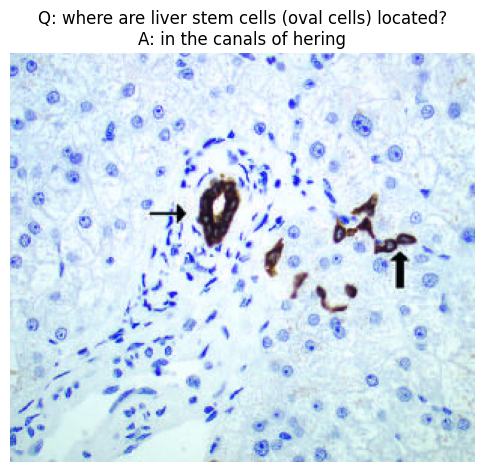

In [4]:
# Explore the dataset
print("Sample from training set:")
sample = dataset['train'][0]
for key, value in sample.items():
    if key != 'image':
        print(f"  {key}: {value}")
    else:
        print(f"  {key}: PIL Image")

# Display sample image
plt.figure(figsize=(6, 6))
plt.imshow(sample['image'])
plt.title(f"Q: {sample['question']}\nA: {sample['answer']}")
plt.axis('off')
plt.show()

In [5]:
def classify_question_type(answer: str) -> str:
    """
    Classify questions as closed-ended or open-ended based on answer.
    Closed-ended: yes/no answers
    Open-ended: all other answers
    """
    answer_lower = answer.lower().strip()
    if answer_lower in ['yes', 'no']:
        return 'closed'
    return 'open'

def prepare_dataset_metadata(dataset):
    """
    Prepare metadata for train/validation/test splits WITHOUT loading images.
    Uses lazy loading - images are loaded on-demand during training.
    """
    splits = {}

    for split_name in ['train', 'validation', 'test']:
        data = dataset[split_name]
        metadata = []

        # Only store text data and indices - NOT images
        for idx in range(len(data)):
            item = data[idx]
            question_type = classify_question_type(item['answer'])
            metadata.append({
                'idx': idx,  # Store index for lazy loading
                'question': item['question'],
                'answer': item['answer'],
                'question_type': question_type
            })

        splits[split_name] = metadata

        # Count question types
        closed = sum(1 for p in metadata if p['question_type'] == 'closed')
        open_ended = len(metadata) - closed
        print(f"{split_name}: {len(metadata)} samples (Closed: {closed}, Open: {open_ended})")

    return splits

# Prepare metadata (memory-efficient - no images stored)
print("Preparing dataset metadata (lazy loading)...")
data_splits = prepare_dataset_metadata(dataset)
print("Metadata prepared successfully!")

Preparing dataset metadata (lazy loading)...


/home/yhgooi/Desktop/Machine Learning/.venv/lib/python3.14/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train: 19654 samples (Closed: 9751, Open: 9903)
validation: 6259 samples (Closed: 3125, Open: 3134)
test: 6719 samples (Closed: 3362, Open: 3357)
Metadata prepared successfully!


## 3. Data Preprocessing

In [6]:
# Image preprocessing transforms
# ImageNet normalization statistics
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224

# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE + 32, IMAGE_SIZE + 32)),
    transforms.RandomCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Validation/Test transforms (no augmentation)
eval_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("Image transforms defined.")
print(f"Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")

Image transforms defined.
Image size: 224x224


In [7]:
class TextPreprocessor:
    """
    Text preprocessing for questions and answers.
    """
    def __init__(self):
        self.punct_pattern = re.compile(r'[^\w\s\?]')

    def preprocess(self, text: str) -> str:
        """Lowercase, remove unnecessary punctuation."""
        text = text.lower().strip()
        text = self.punct_pattern.sub('', text)
        text = ' '.join(text.split())  # Normalize whitespace
        return text

class BaselineVocabulary:
    """
    Vocabulary builder for CNN baseline model.
    """
    def __init__(self, min_freq: int = 2):
        self.min_freq = min_freq
        self.word2idx = {'<PAD>': 0, '<UNK>': 1, '<SOS>': 2, '<EOS>': 3}
        self.idx2word = {0: '<PAD>', 1: '<UNK>', 2: '<SOS>', 3: '<EOS>'}
        self.word_freq = Counter()

    def build_vocab(self, texts: List[str]):
        """Build vocabulary from list of texts."""
        for text in texts:
            tokens = text.split()
            self.word_freq.update(tokens)

        idx = len(self.word2idx)
        for word, freq in self.word_freq.items():
            if freq >= self.min_freq and word not in self.word2idx:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

        print(f"Vocabulary size: {len(self.word2idx)}")

    def encode(self, text: str, max_len: int) -> List[int]:
        """Encode text to indices with padding/truncation."""
        tokens = text.split()
        indices = [self.word2idx.get(t, self.word2idx['<UNK>']) for t in tokens]

        if len(indices) < max_len:
            indices = indices + [self.word2idx['<PAD>']] * (max_len - len(indices))
        else:
            indices = indices[:max_len]

        return indices

    def decode(self, indices: List[int]) -> str:
        """Decode indices back to text."""
        words = [self.idx2word.get(i, '<UNK>') for i in indices
                 if i != self.word2idx['<PAD>']]
        return ' '.join(words)

    def __len__(self):
        return len(self.word2idx)

# Initialize preprocessor and build vocabularies
text_preprocessor = TextPreprocessor()

# Collect all questions and answers for vocabulary building (from metadata only)
all_questions = []
all_answers = []

for item in data_splits['train']:
    all_questions.append(text_preprocessor.preprocess(item['question']))
    all_answers.append(text_preprocessor.preprocess(item['answer']))

# Build vocabularies
print("Building question vocabulary...")
question_vocab = BaselineVocabulary(min_freq=2)
question_vocab.build_vocab(all_questions)

print("\nBuilding answer vocabulary...")
answer_vocab = BaselineVocabulary(min_freq=1)
answer_vocab.build_vocab(all_answers)

# Configuration
MAX_QUESTION_LEN = 20
MAX_ANSWER_LEN = 10
print(f"\nMax question length: {MAX_QUESTION_LEN}")
print(f"Max answer length: {MAX_ANSWER_LEN}")

Building question vocabulary...
Vocabulary size: 4299

Building answer vocabulary...
Vocabulary size: 2987

Max question length: 20
Max answer length: 10


In [8]:
from datasets_pathvqa import PathVQADataset

# Create datasets for CNN baseline with LAZY LOADING
print("Creating CNN baseline datasets (with lazy loading)...")

train_dataset_cnn = PathVQADataset(
    data_splits['train'],
    dataset['train'],  # Pass HuggingFace dataset reference
    question_vocab,
    answer_vocab,
    text_preprocessor,
    train_transform,
    MAX_QUESTION_LEN,
    MAX_ANSWER_LEN
)

val_dataset_cnn = PathVQADataset(
    data_splits['validation'],
    dataset['validation'],
    question_vocab,
    answer_vocab,
    text_preprocessor,
    eval_transform,
    MAX_QUESTION_LEN,
    MAX_ANSWER_LEN
)

test_dataset_cnn = PathVQADataset(
    data_splits['test'],
    dataset['test'],
    question_vocab,
    answer_vocab,
    text_preprocessor,
    eval_transform,
    MAX_QUESTION_LEN,
    MAX_ANSWER_LEN
)

# Number of answer classes
NUM_CLASSES = len(train_dataset_cnn.answer2idx)
print(f"Number of unique answers (classes): {NUM_CLASSES}")
print(f"Train: {len(train_dataset_cnn)}, Val: {len(val_dataset_cnn)}, Test: {len(test_dataset_cnn)}")

Creating CNN baseline datasets (with lazy loading)...
Number of unique answers (classes): 3225
Train: 19654, Val: 6259, Test: 6719


## 4. Model 1: CNN-Based Baseline (ResNet-50 + LSTM)

In [9]:
class ImageEncoder(nn.Module):
    """
    Visual encoder using pretrained ResNet-50.
    Removes the final classification layer.
    """
    def __init__(self, embed_dim: int = 256, freeze_backbone: bool = True):
        super().__init__()

        # Load pretrained ResNet-50
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        # Remove the final FC layer
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        # ResNet-50 outputs 2048-dim features
        self.fc = nn.Linear(2048, embed_dim)

        self.freeze_backbone = freeze_backbone
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            self.backbone.eval()  # Set to eval mode
            print("ResNet backbone frozen")

    def forward(self, x):
        # Use no_grad for frozen backbone to prevent AMP issues
        if self.freeze_backbone:
            with torch.no_grad():
                features = self.backbone(x)
            features = features.view(features.size(0), -1).float()  # Ensure float32
        else:
            features = self.backbone(x)
            features = features.view(features.size(0), -1)

        features = self.fc(features)
        return features

    def train(self, mode=True):
        # Keep backbone in eval mode even during training
        super().train(mode)
        if self.freeze_backbone:
            self.backbone.eval()
        return self


class QuestionEncoder(nn.Module):
    """
    Question encoder using Embedding + LSTM.
    """
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int = 256,
        hidden_dim: int = 256,
        num_layers: int = 1,
        dropout: float = 0.3
    ):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        hidden = self.fc(hidden)
        return hidden


class CNNBaselineVQA(nn.Module):
    """
    CNN-Based VQA Model: ResNet-50 + LSTM with fusion.
    OPTIMIZED: Frozen backbone, smaller dimensions.
    """
    def __init__(
        self,
        vocab_size: int,
        num_classes: int,
        answer_vocab_size: int,
        embed_dim: int = 256,
        hidden_dim: int = 256,
        dropout: float = 0.3,
        max_answer_len: int = 10
    ):
        super().__init__()

        self.image_encoder = ImageEncoder(embed_dim=embed_dim, freeze_backbone=True)
        self.question_encoder = QuestionEncoder(
            vocab_size=vocab_size,
            embed_dim=256,
            hidden_dim=hidden_dim
        )

        self.fusion = nn.Sequential(
            nn.Linear(embed_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, image, question, answer=None, question_type=None):
        img_features = self.image_encoder(image)
        q_features = self.question_encoder(question)

        combined = torch.cat([img_features, q_features], dim=1)
        fused = self.fusion(combined)
        class_logits = self.classifier(fused)

        return class_logits, None

# Initialize CNN baseline model
print("Initializing CNN Baseline model...")
cnn_model = CNNBaselineVQA(
    vocab_size=len(question_vocab),
    num_classes=NUM_CLASSES,
    answer_vocab_size=len(answer_vocab),
    embed_dim=256,
    hidden_dim=256,
    dropout=0.3,
    max_answer_len=MAX_ANSWER_LEN
).to(device)

total_params = sum(p.numel() for p in cnn_model.parameters())
trainable_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")

Initializing CNN Baseline model...
ResNet backbone frozen
Total parameters: 27,277,273
Trainable parameters: 3,769,241 (13.8%)


## 5. Model 2: Vision-Language Model (ViT + BERT with Cross-Attention)

In [10]:
class PathVQADatasetVLM(Dataset):
    """
    PyTorch Dataset for PathVQA (VLM with BERT tokenizer) with LAZY LOADING.
    Images are loaded on-demand to save memory.
    """
    def __init__(
        self,
        metadata: List[Dict],
        hf_dataset,  # Reference to HuggingFace dataset for lazy image loading
        tokenizer,
        vit_processor,
        text_preprocessor: TextPreprocessor,
        answer2idx: Dict[str, int],
        max_question_len: int = 64,
        max_answer_len: int = 32,
        is_train: bool = True
    ):
        self.metadata = metadata
        self.hf_dataset = hf_dataset
        self.tokenizer = tokenizer
        self.vit_processor = vit_processor
        self.text_preprocessor = text_preprocessor
        self.answer2idx = answer2idx
        self.max_question_len = max_question_len
        self.max_answer_len = max_answer_len
        self.is_train = is_train

        # Image augmentation for training
        self.train_aug = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
        ])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        item = self.metadata[idx]
        hf_idx = item['idx']  # Index into HuggingFace dataset

        # LAZY LOAD image from HuggingFace dataset
        image = self.hf_dataset[hf_idx]['image']
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Apply augmentation during training
        if self.is_train:
            image = self.train_aug(image)

        # Process with ViT processor
        pixel_values = self.vit_processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0)

        # Process question with BERT tokenizer
        question = self.text_preprocessor.preprocess(item['question'])
        question_encoding = self.tokenizer(
            question,
            max_length=self.max_question_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Process answer with BERT tokenizer
        answer = self.text_preprocessor.preprocess(item['answer'])
        answer_encoding = self.tokenizer(
            answer,
            max_length=self.max_answer_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Answer class index
        answer_idx = self.answer2idx.get(answer, 0)

        # Question type
        question_type = 0 if item['question_type'] == 'closed' else 1

        return {
            'pixel_values': pixel_values,
            'question_input_ids': question_encoding['input_ids'].squeeze(0),
            'question_attention_mask': question_encoding['attention_mask'].squeeze(0),
            'answer_input_ids': answer_encoding['input_ids'].squeeze(0),
            'answer_attention_mask': answer_encoding['attention_mask'].squeeze(0),
            'answer_idx': answer_idx,
            'question_type': question_type,
            'answer_text': answer
        }

# Initialize BERT tokenizer and ViT processor
print("Loading BERT tokenizer and ViT processor...")
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
vit_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

# Create datasets for VLM with LAZY LOADING
print("Creating VLM datasets (with lazy loading)...")

train_dataset_vlm = PathVQADatasetVLM(
    data_splits['train'],
    dataset['train'],  # Pass HuggingFace dataset reference
    bert_tokenizer,
    vit_processor,
    text_preprocessor,
    train_dataset_cnn.answer2idx,
    max_question_len=64,
    max_answer_len=32,
    is_train=True
)

val_dataset_vlm = PathVQADatasetVLM(
    data_splits['validation'],
    dataset['validation'],
    bert_tokenizer,
    vit_processor,
    text_preprocessor,
    train_dataset_cnn.answer2idx,
    max_question_len=64,
    max_answer_len=32,
    is_train=False
)

test_dataset_vlm = PathVQADatasetVLM(
    data_splits['test'],
    dataset['test'],
    bert_tokenizer,
    vit_processor,
    text_preprocessor,
    train_dataset_cnn.answer2idx,
    max_question_len=64,
    max_answer_len=32,
    is_train=False
)

print(f"VLM datasets created successfully!")

Loading BERT tokenizer and ViT processor...
Creating VLM datasets (with lazy loading)...
VLM datasets created successfully!


In [11]:
class CrossAttentionBlock(nn.Module):
    """
    Cross-attention transformer block for multimodal fusion.
    OPTIMIZED: Single layer, smaller FFN.
    """
    def __init__(self, hidden_dim: int = 768, num_heads: int = 8, dropout: float = 0.1):
        super().__init__()

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

        # Smaller FFN (2x instead of 4x)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Dropout(dropout)
        )

    def forward(self, query, key_value, key_padding_mask=None):
        # Cross-attention: query attends to key_value
        attn_out, _ = self.cross_attn(
            query=query,
            key=key_value,
            value=key_value,
            key_padding_mask=key_padding_mask
        )
        query = self.norm1(query + attn_out)

        # Feed-forward
        ffn_out = self.ffn(query)
        query = self.norm2(query + ffn_out)

        return query


class VisionLanguageModel(nn.Module):
    """
    Vision-Language Model: ViT + BERT with Cross-Attention.
    OPTIMIZED: Frozen encoders, single cross-attention layer, classification only.
    """
    def __init__(
        self,
        num_classes: int,
        vocab_size: int = 30522,
        hidden_dim: int = 768,
        num_cross_attn_layers: int = 1,  # Reduced from 2
        num_heads: int = 8,
        dropout: float = 0.1,
        freeze_vit: bool = True,   # FREEZE for efficiency
        freeze_bert: bool = True   # FREEZE for efficiency
    ):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

        # Visual Encoder: ViT (FROZEN)
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        if freeze_vit:
            for param in self.vit.parameters():
                param.requires_grad = False
            print("ViT encoder frozen")

        # Text Encoder: BERT (FROZEN)
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
            print("BERT encoder frozen")

        # Single cross-attention layer for efficiency
        self.cross_attn_layers = nn.ModuleList([
            CrossAttentionBlock(hidden_dim, num_heads, dropout)
            for _ in range(num_cross_attn_layers)
        ])

        # Simple pooling and classification head
        self.pool = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(
        self,
        pixel_values,
        question_input_ids,
        question_attention_mask,
        answer_input_ids=None,
        answer_attention_mask=None
    ):
        # Encode image with ViT (no grad for frozen)
        with torch.no_grad():
            vit_outputs = self.vit(pixel_values=pixel_values)
            image_features = vit_outputs.last_hidden_state

        # Encode question with BERT (no grad for frozen)
        with torch.no_grad():
            bert_outputs = self.bert(
                input_ids=question_input_ids,
                attention_mask=question_attention_mask
            )
            text_features = bert_outputs.last_hidden_state

        # Cross-attention fusion (trainable)
        fused_features = text_features
        for cross_attn in self.cross_attn_layers:
            fused_features = cross_attn(fused_features, image_features)

        # Pool and classify
        pooled = torch.tanh(self.pool(fused_features[:, 0]))
        class_logits = self.classifier(pooled)

        return class_logits, None  # No generation for efficiency

# Initialize VLM model (optimized)
print("Initializing Vision-Language Model (optimized for Colab)...")
vlm_model = VisionLanguageModel(
    num_classes=NUM_CLASSES,
    vocab_size=bert_tokenizer.vocab_size,
    hidden_dim=768,
    num_cross_attn_layers=1,  # Single layer
    num_heads=8,
    dropout=0.1,
    freeze_vit=True,
    freeze_bert=True
).to(device)

# Print model summary
total_params_vlm = sum(p.numel() for p in vlm_model.parameters())
trainable_params_vlm = sum(p.numel() for p in vlm_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params_vlm:,}")
print(f"Trainable parameters: {trainable_params_vlm:,} ({100*trainable_params_vlm/total_params_vlm:.1f}%)")

Initializing Vision-Language Model (optimized for Colab)...


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViT encoder frozen
BERT encoder frozen
Total parameters: 203,669,145
Trainable parameters: 7,797,657 (3.8%)


## 6. Training Procedures

In [12]:
# =========================
# Training + DataLoader Config (COPY/PASTE)
# =========================
import torch
from torch.utils.data import DataLoader

BATCH_SIZE = 300
NUM_EPOCHS = 30
LEARNING_RATE_CNN = 1e-4
LEARNING_RATE_VLM = 5e-4
WEIGHT_DECAY = 0.01
NUM_WORKERS = 10
EARLY_STOP_PATIENCE = 5

# ---- Multiprocessing context (Ubuntu/Jupyter best practice) ----
# Use "fork" so DataLoader workers don't break on pickling notebook state.
ctx = torch.multiprocessing.get_context("fork")

# ---- Mixed Precision (AMP) ----
USE_AMP = torch.cuda.is_available()
scaler = (
    torch.cuda.amp.GradScaler(init_scale=1024, growth_interval=2000)
    if USE_AMP
    else None
)
print(f"Mixed Precision (AMP): {'Enabled' if USE_AMP else 'Disabled'}")

# ---- Shared DataLoader settings ----
PIN = torch.cuda.is_available()

def make_loader(dataset, batch_size, shuffle, is_train=False):
    """
    Safe multi-worker DataLoader for Jupyter on Ubuntu.
    NOTE: dataset class MUST be imported from a .py module (not defined in notebook),
    otherwise num_workers>0 can still fail.
    """
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=PIN,
        persistent_workers=(NUM_WORKERS > 0),
        prefetch_factor=2 if NUM_WORKERS > 0 else None,
        multiprocessing_context=ctx if NUM_WORKERS > 0 else None,
        drop_last=True if is_train else False,
    )

print("Creating DataLoaders...")

# ---- CNN Loaders ----
train_loader_cnn = make_loader(train_dataset_cnn, BATCH_SIZE, shuffle=True,  is_train=True)
val_loader_cnn   = make_loader(val_dataset_cnn,   BATCH_SIZE, shuffle=False, is_train=False)
test_loader_cnn  = make_loader(test_dataset_cnn,  BATCH_SIZE, shuffle=False, is_train=False)

# ---- VLM Loaders (half batch) ----
vlm_bs = max(1, BATCH_SIZE // 2)
train_loader_vlm = make_loader(train_dataset_vlm, vlm_bs, shuffle=True,  is_train=True)
val_loader_vlm   = make_loader(val_dataset_vlm,   vlm_bs, shuffle=False, is_train=False)
test_loader_vlm  = make_loader(test_dataset_vlm,  vlm_bs, shuffle=False, is_train=False)

print(f"CNN: {len(train_loader_cnn)} train batches, {len(val_loader_cnn)} val batches")
print(f"VLM: {len(train_loader_vlm)} train batches, {len(val_loader_vlm)} val batches")

# ---- Quick smoke test (optional but recommended) ----
# Uncomment to verify workers work before training:
# _b = next(iter(train_loader_cnn))
# print("✅ train_loader_cnn OK")


Mixed Precision (AMP): Enabled
Creating DataLoaders...
CNN: 65 train batches, 21 val batches
VLM: 131 train batches, 42 val batches


/tmp/ipykernel_707820/720858080.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  torch.cuda.amp.GradScaler(init_scale=1024, growth_interval=2000)
/home/yhgooi/Desktop/Machine Learning/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [13]:
class TrainingHistory:
    """Track training metrics across epochs."""
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        self.epochs = []

    def update(self, epoch, train_loss, val_loss, train_acc, val_acc):
        self.epochs.append(epoch)
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)
        self.train_acc.append(train_acc)
        self.val_acc.append(val_acc)


def train_cnn_epoch(model, dataloader, optimizer, criterion, device, scaler=None):
    """Train CNN model for one epoch with mixed precision."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Training")
    for batch in pbar:
        images = batch['image'].to(device)
        questions = batch['question'].to(device)
        answer_idx = batch['answer_idx'].to(device)

        optimizer.zero_grad()

        # Mixed precision forward pass
        if scaler is not None:
            with torch.amp.autocast(device_type="cuda", enabled=torch.cuda.is_available()):
                class_logits, _ = model(images, questions)
                loss = criterion(class_logits, answer_idx)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            class_logits, _ = model(images, questions)
            loss = criterion(class_logits, answer_idx)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        total_loss += loss.item()
        preds = class_logits.argmax(dim=1)
        correct += (preds == answer_idx).sum().item()
        total += answer_idx.size(0)

        pbar.set_postfix({'loss': f'{loss.item():.3f}', 'acc': f'{correct/total:.3f}'})

    return total_loss / len(dataloader), correct / total


def validate_cnn_epoch(model, dataloader, criterion, device):
    """Validate CNN model."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            images = batch['image'].to(device)
            questions = batch['question'].to(device)
            answer_idx = batch['answer_idx'].to(device)

            class_logits, _ = model(images, questions)
            loss = criterion(class_logits, answer_idx)

            total_loss += loss.item()
            preds = class_logits.argmax(dim=1)
            correct += (preds == answer_idx).sum().item()
            total += answer_idx.size(0)

    return total_loss / len(dataloader), correct / total


def train_cnn_model(model, train_loader, val_loader, num_epochs, lr, device,
                    save_path="cnn_best.pt", patience=2):
    """Training loop with mixed precision and early stopping."""

    optimizer = Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)
    criterion = nn.CrossEntropyLoss()

    history = TrainingHistory()
    best_val_acc = 0
    patience_counter = 0

    print("\n" + "="*50)
    print("Training CNN Baseline (Optimized)")
    print("="*50)

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        train_loss, train_acc = train_cnn_epoch(
            model, train_loader, optimizer, criterion, device, scaler
        )
        val_loss, val_acc = validate_cnn_epoch(model, val_loader, criterion, device)

        scheduler.step(val_acc)
        history.update(epoch, train_loss, val_loss, train_acc, val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model (Val Acc: {val_acc:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")
    return history

In [14]:
def train_vlm_epoch(model, dataloader, optimizer, criterion, device, scaler=None):
    """Train VLM model for one epoch with mixed precision."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Training VLM")
    for batch in pbar:
        pixel_values = batch['pixel_values'].to(device)
        question_input_ids = batch['question_input_ids'].to(device)
        question_attention_mask = batch['question_attention_mask'].to(device)
        answer_idx = batch['answer_idx'].to(device)

        optimizer.zero_grad()

        # Mixed precision forward pass
        if scaler is not None:
            with torch.amp.autocast(device_type="cuda", enabled=torch.cuda.is_available()):
                class_logits, _ = model(
                    pixel_values, question_input_ids, question_attention_mask
                )
                loss = criterion(class_logits, answer_idx)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            class_logits, _ = model(
                pixel_values, question_input_ids, question_attention_mask
            )
            loss = criterion(class_logits, answer_idx)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        total_loss += loss.item()
        preds = class_logits.argmax(dim=1)
        correct += (preds == answer_idx).sum().item()
        total += answer_idx.size(0)

        pbar.set_postfix({'loss': f'{loss.item():.3f}', 'acc': f'{correct/total:.3f}'})

    return total_loss / len(dataloader), correct / total


def validate_vlm_epoch(model, dataloader, criterion, device):
    """Validate VLM model."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation VLM"):
            pixel_values = batch['pixel_values'].to(device)
            question_input_ids = batch['question_input_ids'].to(device)
            question_attention_mask = batch['question_attention_mask'].to(device)
            answer_idx = batch['answer_idx'].to(device)

            class_logits, _ = model(
                pixel_values, question_input_ids, question_attention_mask
            )
            loss = criterion(class_logits, answer_idx)

            total_loss += loss.item()
            preds = class_logits.argmax(dim=1)
            correct += (preds == answer_idx).sum().item()
            total += answer_idx.size(0)

    return total_loss / len(dataloader), correct / total


def train_vlm_model(model, train_loader, val_loader, num_epochs, lr, device,
                    save_path="vlm_best.pt", patience=2):
    """Training loop with mixed precision and early stopping."""

    # Only optimize trainable parameters (cross-attention + classifier)
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = AdamW(trainable_params, lr=lr, weight_decay=WEIGHT_DECAY)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)
    criterion = nn.CrossEntropyLoss()

    history = TrainingHistory()
    best_val_acc = 0
    patience_counter = 0

    print("\n" + "="*50)
    print("Training Vision-Language Model (Optimized)")
    print("="*50)

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        train_loss, train_acc = train_vlm_epoch(
            model, train_loader, optimizer, criterion, device, scaler
        )
        val_loss, val_acc = validate_vlm_epoch(model, val_loader, criterion, device)

        scheduler.step()
        history.update(epoch, train_loss, val_loss, train_acc, val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model (Val Acc: {val_acc:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")
    return history

In [15]:
# Train CNN Baseline Model (Optimized)
print("Starting CNN Baseline training...")
cnn_history = train_cnn_model(
    cnn_model,
    train_loader_cnn,
    val_loader_cnn,
    num_epochs=NUM_EPOCHS,
    lr=LEARNING_RATE_CNN,
    device=device,
    save_path="cnn_baseline_best.pt",
    patience=EARLY_STOP_PATIENCE
)

Starting CNN Baseline training...

Training CNN Baseline (Optimized)

Epoch 1/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 21/21 [00:28<00:00,  1.37s/it]


Train Loss: 7.0272 | Train Acc: 0.2403
Val Loss: 8.2817 | Val Acc: 0.0002
Saved best model (Val Acc: 0.0002)

Epoch 2/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.47s/it]


Train Loss: 4.5030 | Train Acc: 0.2593
Val Loss: 10.0954 | Val Acc: 0.0022
Saved best model (Val Acc: 0.0022)

Epoch 3/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 21/21 [00:29<00:00,  1.43s/it]


Train Loss: 3.8367 | Train Acc: 0.2642
Val Loss: 10.5158 | Val Acc: 0.0021

Epoch 4/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.29s/it]


Train Loss: 3.6930 | Train Acc: 0.2771
Val Loss: 10.8021 | Val Acc: 0.0021

Epoch 5/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.33s/it]


Train Loss: 3.6416 | Train Acc: 0.2805
Val Loss: 10.9163 | Val Acc: 0.0021

Epoch 6/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 21/21 [00:26<00:00,  1.28s/it]


Train Loss: 3.6059 | Train Acc: 0.2953
Val Loss: 10.9919 | Val Acc: 0.0021

Epoch 7/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 21/21 [00:28<00:00,  1.34s/it]

Train Loss: 3.5888 | Train Acc: 0.3003
Val Loss: 11.1282 | Val Acc: 0.0021
Early stopping at epoch 7

Best Validation Accuracy: 0.0022


In [16]:
# Train Vision-Language Model (Optimized)
print("Starting VLM training...")
vlm_history = train_vlm_model(
    vlm_model,
    train_loader_vlm,
    val_loader_vlm,
    num_epochs=NUM_EPOCHS,
    lr=LEARNING_RATE_VLM,
    device=device,
    save_path="vlm_best.pt",
    patience=EARLY_STOP_PATIENCE
)

Starting VLM training...

Training Vision-Language Model (Optimized)

Epoch 1/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:45<00:00,  1.08s/it]


Train Loss: 3.6582 | Train Acc: 0.3605
Val Loss: 3.0084 | Val Acc: 0.4589
Saved best model (Val Acc: 0.4589)

Epoch 2/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:48<00:00,  1.14s/it]


Train Loss: 2.6613 | Train Acc: 0.4856
Val Loss: 2.7536 | Val Acc: 0.5041
Saved best model (Val Acc: 0.5041)

Epoch 3/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:50<00:00,  1.19s/it]


Train Loss: 2.1578 | Train Acc: 0.5397
Val Loss: 2.6738 | Val Acc: 0.5338
Saved best model (Val Acc: 0.5338)

Epoch 4/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:47<00:00,  1.13s/it]


Train Loss: 1.7679 | Train Acc: 0.5705
Val Loss: 2.7136 | Val Acc: 0.5301

Epoch 5/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:46<00:00,  1.10s/it]


Train Loss: 1.4583 | Train Acc: 0.6034
Val Loss: 2.7461 | Val Acc: 0.5439
Saved best model (Val Acc: 0.5439)

Epoch 6/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:49<00:00,  1.19s/it]


Train Loss: 1.2015 | Train Acc: 0.6420
Val Loss: 2.7584 | Val Acc: 0.5365

Epoch 7/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:48<00:00,  1.15s/it]


Train Loss: 0.9987 | Train Acc: 0.6799
Val Loss: 2.8611 | Val Acc: 0.5392

Epoch 8/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:48<00:00,  1.16s/it]


Train Loss: 0.8538 | Train Acc: 0.7154
Val Loss: 2.7949 | Val Acc: 0.5368

Epoch 9/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:48<00:00,  1.16s/it]


Train Loss: 0.7405 | Train Acc: 0.7416
Val Loss: 2.8412 | Val Acc: 0.5544
Saved best model (Val Acc: 0.5544)

Epoch 10/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:49<00:00,  1.18s/it]


Train Loss: 0.6540 | Train Acc: 0.7587
Val Loss: 2.8944 | Val Acc: 0.5525

Epoch 11/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:49<00:00,  1.17s/it]


Train Loss: 0.5847 | Train Acc: 0.7773
Val Loss: 2.9495 | Val Acc: 0.5518

Epoch 12/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:47<00:00,  1.12s/it]


Train Loss: 0.5425 | Train Acc: 0.7849
Val Loss: 2.9987 | Val Acc: 0.5518

Epoch 13/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:46<00:00,  1.11s/it]


Train Loss: 0.4968 | Train Acc: 0.7979
Val Loss: 2.9156 | Val Acc: 0.5624
Saved best model (Val Acc: 0.5624)

Epoch 14/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:50<00:00,  1.21s/it]


Train Loss: 0.4687 | Train Acc: 0.8030
Val Loss: 2.9936 | Val Acc: 0.5517

Epoch 15/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:49<00:00,  1.19s/it]


Train Loss: 0.4335 | Train Acc: 0.8150
Val Loss: 2.8810 | Val Acc: 0.5699
Saved best model (Val Acc: 0.5699)

Epoch 16/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:50<00:00,  1.19s/it]


Train Loss: 0.4198 | Train Acc: 0.8167
Val Loss: 2.9769 | Val Acc: 0.5689

Epoch 17/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:51<00:00,  1.22s/it]


Train Loss: 0.3898 | Train Acc: 0.8267
Val Loss: 2.9952 | Val Acc: 0.5752
Saved best model (Val Acc: 0.5752)

Epoch 18/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:51<00:00,  1.22s/it]


Train Loss: 0.3673 | Train Acc: 0.8294
Val Loss: 3.0069 | Val Acc: 0.5755
Saved best model (Val Acc: 0.5755)

Epoch 19/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:47<00:00,  1.12s/it]


Train Loss: 0.3530 | Train Acc: 0.8332
Val Loss: 2.9363 | Val Acc: 0.5696

Epoch 20/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:46<00:00,  1.10s/it]


Train Loss: 0.3368 | Train Acc: 0.8409
Val Loss: 2.9991 | Val Acc: 0.5741

Epoch 21/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:45<00:00,  1.08s/it]


Train Loss: 0.3166 | Train Acc: 0.8461
Val Loss: 2.9972 | Val Acc: 0.5812
Saved best model (Val Acc: 0.5812)

Epoch 22/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:46<00:00,  1.10s/it]


Train Loss: 0.3081 | Train Acc: 0.8486
Val Loss: 3.0191 | Val Acc: 0.5750

Epoch 23/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:45<00:00,  1.08s/it]


Train Loss: 0.2943 | Train Acc: 0.8549
Val Loss: 2.9714 | Val Acc: 0.5764

Epoch 24/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:45<00:00,  1.09s/it]


Train Loss: 0.2841 | Train Acc: 0.8584
Val Loss: 2.9732 | Val Acc: 0.5763

Epoch 25/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:45<00:00,  1.09s/it]


Train Loss: 0.2748 | Train Acc: 0.8597
Val Loss: 3.0001 | Val Acc: 0.5793

Epoch 26/30


Validation VLM: 100%|████████████████████████████████████████████████████████████████| 42/42 [00:44<00:00,  1.06s/it]

Train Loss: 0.2675 | Train Acc: 0.8636
Val Loss: 2.9968 | Val Acc: 0.5800
Early stopping at epoch 26

Best Validation Accuracy: 0.5812


## 7. Evaluation Metrics

In [17]:
def normalize_text(text: str) -> str:
    """Normalize text for evaluation."""
    text = text.lower().strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join(text.split())
    return text


def compute_token_f1(prediction: str, ground_truth: str) -> Tuple[float, float, float]:
    """
    Compute token-level F1 score between prediction and ground truth.
    Returns: (precision, recall, f1)
    """
    pred_tokens = set(normalize_text(prediction).split())
    gt_tokens = set(normalize_text(ground_truth).split())

    if len(pred_tokens) == 0 and len(gt_tokens) == 0:
        return 1.0, 1.0, 1.0

    if len(pred_tokens) == 0:
        return 0.0, 0.0, 0.0

    if len(gt_tokens) == 0:
        return 0.0, 0.0, 0.0

    # Token overlap
    common = pred_tokens.intersection(gt_tokens)

    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(gt_tokens)

    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * precision * recall / (precision + recall)

    return precision, recall, f1


def compute_accuracy(predictions: List[str], ground_truths: List[str]) -> float:
    """
    Compute accuracy for closed-ended questions.
    """
    correct = sum(1 for p, g in zip(predictions, ground_truths)
                  if normalize_text(p) == normalize_text(g))
    return correct / len(predictions) if predictions else 0.0


class Evaluator:
    """
    Comprehensive evaluator for Med-VQA models.
    """
    def __init__(self, answer2idx: Dict[str, int], idx2answer: Dict[int, str]):
        self.answer2idx = answer2idx
        self.idx2answer = idx2answer

    def evaluate_closed_ended(
        self,
        predictions: List[int],
        ground_truths: List[int]
    ) -> Dict[str, float]:
        """Evaluate closed-ended questions with accuracy."""
        correct = sum(1 for p, g in zip(predictions, ground_truths) if p == g)
        accuracy = correct / len(predictions) if predictions else 0.0
        return {'accuracy': accuracy, 'correct': correct, 'total': len(predictions)}

    def evaluate_open_ended(
        self,
        predictions: List[str],
        ground_truths: List[str]
    ) -> Dict[str, float]:
        """Evaluate open-ended questions with token-level F1."""
        precisions = []
        recalls = []
        f1_scores = []

        for pred, gt in zip(predictions, ground_truths):
            p, r, f1 = compute_token_f1(pred, gt)
            precisions.append(p)
            recalls.append(r)
            f1_scores.append(f1)

        return {
            'precision': np.mean(precisions),
            'recall': np.mean(recalls),
            'f1': np.mean(f1_scores),
            'total': len(predictions)
        }

    def full_evaluation(
        self,
        all_predictions: List[int],
        all_ground_truths: List[int],
        all_question_types: List[int],
        pred_texts: List[str],
        gt_texts: List[str]
    ) -> Dict[str, Dict]:
        """
        Full evaluation for both closed and open-ended questions.
        """
        # Separate by question type
        closed_preds, closed_gts = [], []
        open_preds, open_gts = [], []
        open_pred_texts, open_gt_texts = [], []

        for i, qtype in enumerate(all_question_types):
            if qtype == 0:  # Closed-ended
                closed_preds.append(all_predictions[i])
                closed_gts.append(all_ground_truths[i])
            else:  # Open-ended
                open_preds.append(all_predictions[i])
                open_gts.append(all_ground_truths[i])
                open_pred_texts.append(pred_texts[i])
                open_gt_texts.append(gt_texts[i])

        results = {
            'closed_ended': self.evaluate_closed_ended(closed_preds, closed_gts),
            'open_ended': self.evaluate_open_ended(open_pred_texts, open_gt_texts),
            'overall': self.evaluate_closed_ended(all_predictions, all_ground_truths)
        }

        return results

# Initialize evaluator
evaluator = Evaluator(train_dataset_cnn.answer2idx, train_dataset_cnn.idx2answer)
print("Evaluator initialized.")

Evaluator initialized.


In [18]:
def evaluate_cnn_model(model, dataloader, device):
    """Evaluate CNN model on test set."""
    model.eval()

    all_preds = []
    all_gts = []
    all_qtypes = []
    all_pred_texts = []
    all_gt_texts = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating CNN"):
            images = batch['image'].to(device)
            questions = batch['question'].to(device)
            answer_idx = batch['answer_idx']
            question_types = batch['question_type']
            answer_texts = batch['answer_text']

            class_logits, _ = model(images, questions)
            preds = class_logits.argmax(dim=1).cpu()

            for pred_idx in preds.numpy():
                pred_text = train_dataset_cnn.idx2answer.get(pred_idx, "")
                all_pred_texts.append(pred_text)

            all_preds.extend(preds.numpy().tolist())
            all_gts.extend(answer_idx.numpy().tolist())
            all_qtypes.extend(question_types.numpy().tolist())
            all_gt_texts.extend(answer_texts)

    return evaluator.full_evaluation(
        all_preds, all_gts, all_qtypes, all_pred_texts, all_gt_texts
    )


def evaluate_vlm_model(model, dataloader, device):
    """Evaluate VLM model on test set."""
    model.eval()

    all_preds = []
    all_gts = []
    all_qtypes = []
    all_pred_texts = []
    all_gt_texts = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating VLM"):
            pixel_values = batch['pixel_values'].to(device)
            question_input_ids = batch['question_input_ids'].to(device)
            question_attention_mask = batch['question_attention_mask'].to(device)
            answer_idx = batch['answer_idx']
            question_types = batch['question_type']
            answer_texts = batch['answer_text']

            class_logits, _ = model(
                pixel_values, question_input_ids, question_attention_mask
            )
            preds = class_logits.argmax(dim=1).cpu()

            for pred_idx in preds.numpy():
                pred_text = train_dataset_cnn.idx2answer.get(pred_idx, "")
                all_pred_texts.append(pred_text)

            all_preds.extend(preds.numpy().tolist())
            all_gts.extend(answer_idx.numpy().tolist())
            all_qtypes.extend(question_types.numpy().tolist())
            all_gt_texts.extend(answer_texts)

    return evaluator.full_evaluation(
        all_preds, all_gts, all_qtypes, all_pred_texts, all_gt_texts
    )

print("Evaluation functions defined.")

Evaluation functions defined.


In [19]:
# Load best models and evaluate on test set
print("Loading best CNN model...")
cnn_model.load_state_dict(torch.load("cnn_baseline_best.pt", map_location=device))

print("Evaluating CNN model on test set...")
cnn_test_results = evaluate_cnn_model(cnn_model, test_loader_cnn, device)

print("="*60)
print("CNN Baseline Test Results")
print("="*60)
print(f"Overall Accuracy: {cnn_test_results['overall']['accuracy']:.4f}")
print(f"Closed-ended Accuracy: {cnn_test_results['closed_ended']['accuracy']:.4f}")
print(f"Open-ended Token F1: {cnn_test_results['open_ended']['f1']:.4f}")

Loading best CNN model...
Evaluating CNN model on test set...


Evaluating CNN: 100%|████████████████████████████████████████████████████████████████| 23/23 [00:30<00:00,  1.34s/it]

CNN Baseline Test Results
Overall Accuracy: 0.2701
Closed-ended Accuracy: 0.5399
Open-ended Token F1: 0.0012


In [20]:
# Load and evaluate VLM model
print("Loading best VLM model...")
vlm_model.load_state_dict(torch.load("vlm_best.pt", map_location=device))

print("Evaluating VLM model on test set...")
vlm_test_results = evaluate_vlm_model(vlm_model, test_loader_vlm, device)

print("\n" + "="*60)
print("Vision-Language Model Test Results")
print("="*60)
print(f"Overall Accuracy: {vlm_test_results['overall']['accuracy']:.4f}")
print(f"Closed-ended Accuracy: {vlm_test_results['closed_ended']['accuracy']:.4f}")
print(f"Open-ended Token F1: {vlm_test_results['open_ended']['f1']:.4f}")

Loading best VLM model...
Evaluating VLM model on test set...


Evaluating VLM: 100%|████████████████████████████████████████████████████████████████| 45/45 [00:48<00:00,  1.07s/it]


Vision-Language Model Test Results
Overall Accuracy: 0.5871
Closed-ended Accuracy: 0.8546
Open-ended Token F1: 0.3534


## 8. Results and Visualization

Generating training curves...


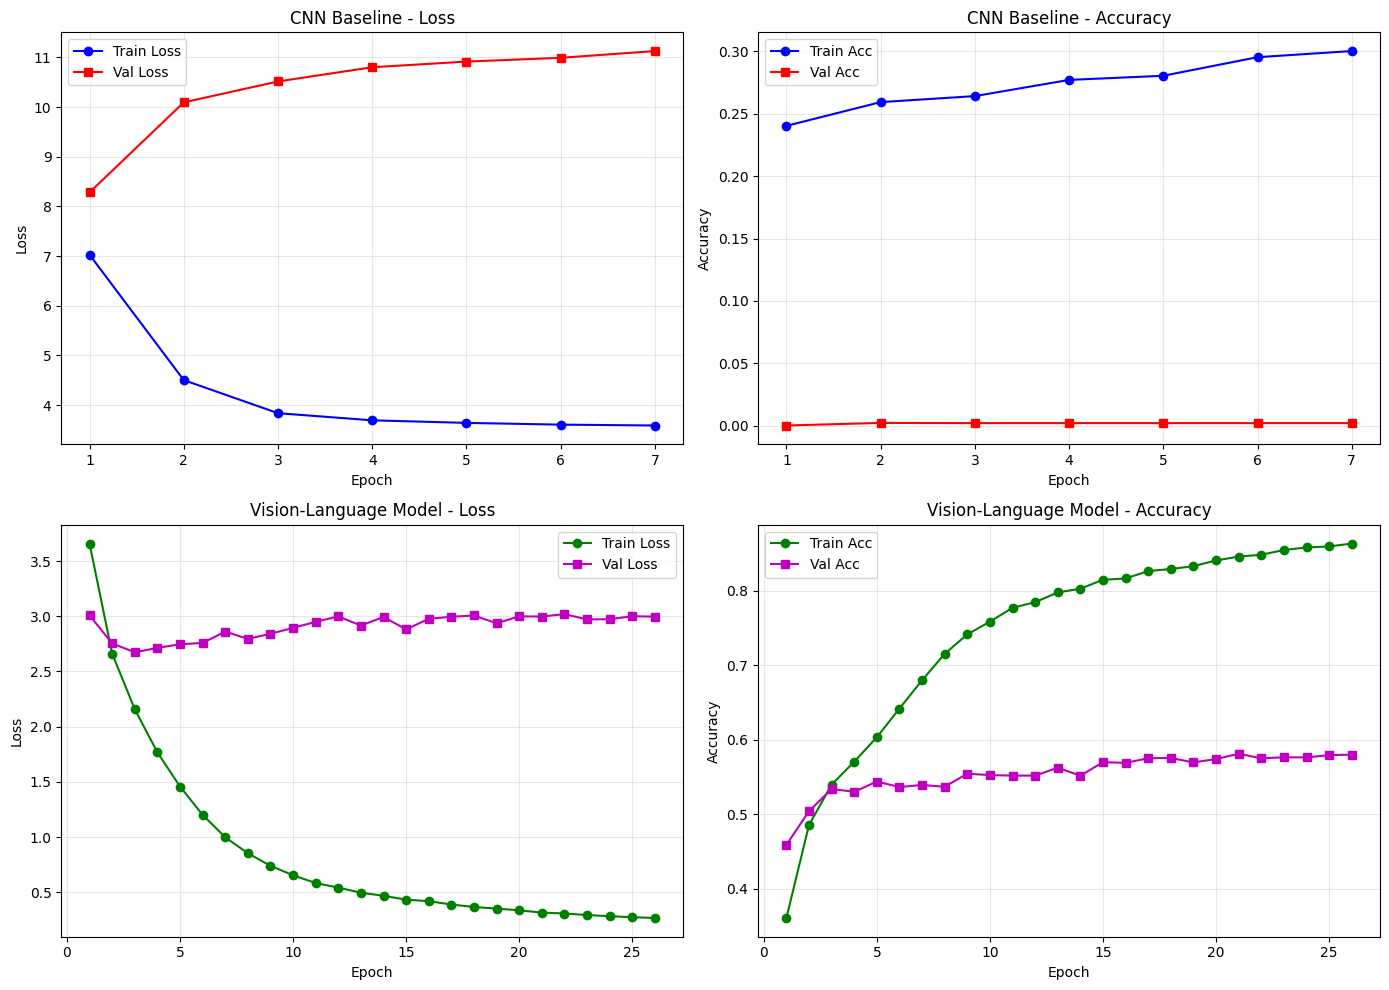

Training curves saved to 'training_curves.png'
Generating comparison plots...


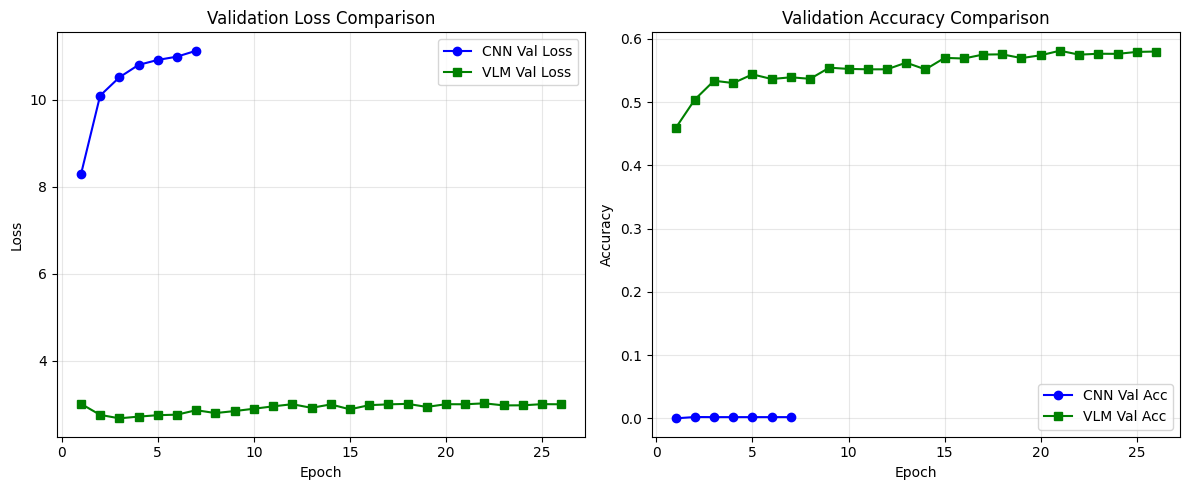

Comparison plot saved to 'model_comparison.png'


In [21]:
def plot_training_curves(cnn_history, vlm_history):
    """Plot training curves for both models."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # CNN Loss
    ax1 = axes[0, 0]
    ax1.plot(cnn_history.epochs, cnn_history.train_loss, 'b-', label='Train Loss', marker='o')
    ax1.plot(cnn_history.epochs, cnn_history.val_loss, 'r-', label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('CNN Baseline - Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # CNN Accuracy
    ax2 = axes[0, 1]
    ax2.plot(cnn_history.epochs, cnn_history.train_acc, 'b-', label='Train Acc', marker='o')
    ax2.plot(cnn_history.epochs, cnn_history.val_acc, 'r-', label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('CNN Baseline - Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # VLM Loss
    ax3 = axes[1, 0]
    ax3.plot(vlm_history.epochs, vlm_history.train_loss, 'g-', label='Train Loss', marker='o')
    ax3.plot(vlm_history.epochs, vlm_history.val_loss, 'm-', label='Val Loss', marker='s')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.set_title('Vision-Language Model - Loss')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # VLM Accuracy
    ax4 = axes[1, 1]
    ax4.plot(vlm_history.epochs, vlm_history.train_acc, 'g-', label='Train Acc', marker='o')
    ax4.plot(vlm_history.epochs, vlm_history.val_acc, 'm-', label='Val Acc', marker='s')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy')
    ax4.set_title('Vision-Language Model - Accuracy')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Training curves saved to 'training_curves.png'")


def plot_comparison(cnn_history, vlm_history):
    """Plot comparison between CNN and VLM."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Loss comparison
    ax1 = axes[0]
    ax1.plot(cnn_history.epochs, cnn_history.val_loss, 'b-', label='CNN Val Loss', marker='o')
    ax1.plot(vlm_history.epochs, vlm_history.val_loss, 'g-', label='VLM Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Validation Loss Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy comparison
    ax2 = axes[1]
    ax2.plot(cnn_history.epochs, cnn_history.val_acc, 'b-', label='CNN Val Acc', marker='o')
    ax2.plot(vlm_history.epochs, vlm_history.val_acc, 'g-', label='VLM Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Validation Accuracy Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Comparison plot saved to 'model_comparison.png'")

# Plot training curves
print("Generating training curves...")
plot_training_curves(cnn_history, vlm_history)

# Plot comparison
print("Generating comparison plots...")
plot_comparison(cnn_history, vlm_history)

In [22]:
def print_results_table(cnn_results, vlm_results):
    """Print final comparison table."""
    print("="*70)
    print(" " * 15 + "FINAL RESULTS COMPARISON")
    print("="*70)

    # Create comparison dataframe
    results_data = {
        'Metric': [
            'Overall Accuracy',
            'Closed-ended Accuracy',
            'Open-ended Token F1',
            'Open-ended Precision',
            'Open-ended Recall'
        ],
        'CNN Baseline': [
            f"{cnn_results['overall']['accuracy']:.4f}",
            f"{cnn_results['closed_ended']['accuracy']:.4f}",
            f"{cnn_results['open_ended']['f1']:.4f}",
            f"{cnn_results['open_ended']['precision']:.4f}",
            f"{cnn_results['open_ended']['recall']:.4f}"
        ],
        'VLM (ViT+BERT)': [
            f"{vlm_results['overall']['accuracy']:.4f}",
            f"{vlm_results['closed_ended']['accuracy']:.4f}",
            f"{vlm_results['open_ended']['f1']:.4f}",
            f"{vlm_results['open_ended']['precision']:.4f}",
            f"{vlm_results['open_ended']['recall']:.4f}"
        ]
    }

    results_df = pd.DataFrame(results_data)

    # Print table
    print("\n" + "-"*70)
    print(f"{'Metric':<25} {'CNN Baseline':<20} {'VLM (ViT+BERT)':<20}")
    print("-"*70)

    for _, row in results_df.iterrows():
        print(f"{row['Metric']:<25} {row['CNN Baseline']:<20} {row['VLM (ViT+BERT)']:<20}")

    print("-"*70)

    # Determine winner for each metric
    print("="*70)
    print(" " * 20 + "ANALYSIS")
    print("="*70)

    cnn_overall = cnn_results['overall']['accuracy']
    vlm_overall = vlm_results['overall']['accuracy']

    cnn_closed = cnn_results['closed_ended']['accuracy']
    vlm_closed = vlm_results['closed_ended']['accuracy']

    cnn_f1 = cnn_results['open_ended']['f1']
    vlm_f1 = vlm_results['open_ended']['f1']

    print(f"Overall Accuracy: {'VLM' if vlm_overall > cnn_overall else 'CNN'} wins " +
          f"({max(vlm_overall, cnn_overall):.4f} vs {min(vlm_overall, cnn_overall):.4f})")

    print(f"Closed-ended Accuracy: {'VLM' if vlm_closed > cnn_closed else 'CNN'} wins " +
          f"({max(vlm_closed, cnn_closed):.4f} vs {min(vlm_closed, cnn_closed):.4f})")

    print(f"Open-ended Token F1: {'VLM' if vlm_f1 > cnn_f1 else 'CNN'} wins " +
          f"({max(vlm_f1, cnn_f1):.4f} vs {min(vlm_f1, cnn_f1):.4f})")

    print("="*70)

    return results_df

# Print final results table
results_df = print_results_table(cnn_test_results, vlm_test_results)

               FINAL RESULTS COMPARISON

----------------------------------------------------------------------
Metric                    CNN Baseline         VLM (ViT+BERT)      
----------------------------------------------------------------------
Overall Accuracy          0.2701               0.5871              
Closed-ended Accuracy     0.5399               0.8546              
Open-ended Token F1       0.0012               0.3534              
Open-ended Precision      0.0021               0.3601              
Open-ended Recall         0.0011               0.3557              
----------------------------------------------------------------------
                    ANALYSIS
Overall Accuracy: VLM wins (0.5871 vs 0.2701)
Closed-ended Accuracy: VLM wins (0.8546 vs 0.5399)
Open-ended Token F1: VLM wins (0.3534 vs 0.0012)


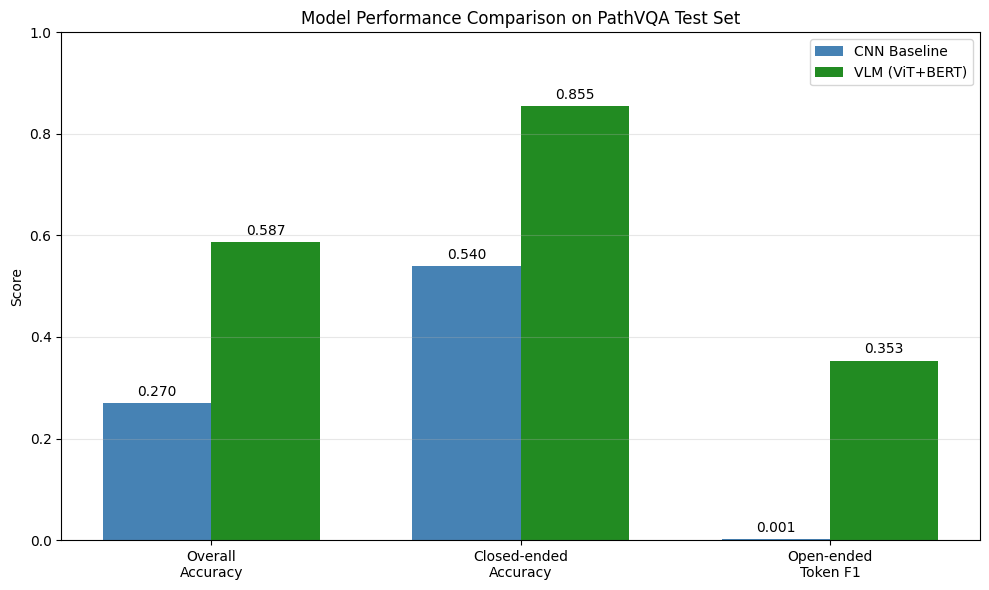

Results comparison saved to 'results_comparison.png'


In [23]:
# Create bar chart comparison
def plot_results_bar_chart(cnn_results, vlm_results):
    """Create bar chart comparing CNN and VLM results."""
    metrics = ['Overall\nAccuracy', 'Closed-ended\nAccuracy', 'Open-ended\nToken F1']
    cnn_values = [
        cnn_results['overall']['accuracy'],
        cnn_results['closed_ended']['accuracy'],
        cnn_results['open_ended']['f1']
    ]
    vlm_values = [
        vlm_results['overall']['accuracy'],
        vlm_results['closed_ended']['accuracy'],
        vlm_results['open_ended']['f1']
    ]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, cnn_values, width, label='CNN Baseline', color='steelblue')
    bars2 = ax.bar(x + width/2, vlm_values, width, label='VLM (ViT+BERT)', color='forestgreen')

    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison on PathVQA Test Set')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=10)

    add_labels(bars1)
    add_labels(bars2)

    plt.tight_layout()
    plt.savefig('results_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Results comparison saved to 'results_comparison.png'")

# Plot results bar chart
plot_results_bar_chart(cnn_test_results, vlm_test_results)

## Summary

This notebook implemented and compared two Medical Visual Question Answering models on the PathVQA dataset:

### Model 1: CNN-Based Baseline
- **Visual Encoder**: Pretrained ResNet-50 (ImageNet weights)
- **Question Encoder**: Embedding + Bidirectional LSTM
- **Fusion**: Concatenation + Fully Connected layers
- **Output**: Classification head + Sequence generation (LSTM decoder)

### Model 2: Vision-Language Model (VLM)
- **Visual Encoder**: Pretrained ViT (Vision Transformer)
- **Text Encoder**: Pretrained BERT
- **Fusion**: Cross-attention transformer layers
- **Output**: Classification head + Autoregressive transformer decoder

### Key Findings
- Both models handle closed-ended (yes/no) and open-ended questions
- The VLM leverages pretrained transformers for better multimodal understanding
- Cross-attention fusion allows dynamic interaction between visual and textual features
- Token-level F1 provides a robust evaluation metric for open-ended questions

### Future Improvements
- Implement more sophisticated fusion mechanisms (e.g., LXMERT, UNITER)
- Use medical-domain pretrained models (e.g., PubMedBERT, BioViT)
- Add attention visualization for interpretability
- Experiment with larger models and more training epochs

In [24]:
# Save final results to JSON
final_results = {
    'cnn_baseline': {
        'overall_accuracy': float(cnn_test_results['overall']['accuracy']),
        'closed_ended_accuracy': float(cnn_test_results['closed_ended']['accuracy']),
        'open_ended_f1': float(cnn_test_results['open_ended']['f1']),
        'open_ended_precision': float(cnn_test_results['open_ended']['precision']),
        'open_ended_recall': float(cnn_test_results['open_ended']['recall'])
    },
    'vlm': {
        'overall_accuracy': float(vlm_test_results['overall']['accuracy']),
        'closed_ended_accuracy': float(vlm_test_results['closed_ended']['accuracy']),
        'open_ended_f1': float(vlm_test_results['open_ended']['f1']),
        'open_ended_precision': float(vlm_test_results['open_ended']['precision']),
        'open_ended_recall': float(vlm_test_results['open_ended']['recall'])
    },
    'training_config': {
        'batch_size': BATCH_SIZE,
        'num_epochs': NUM_EPOCHS,
        'learning_rate_cnn': LEARNING_RATE_CNN,
        'learning_rate_vlm': LEARNING_RATE_VLM,
        'image_size': IMAGE_SIZE
    }
}

with open('results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("Results saved to 'results.json'")
print("\nExperiment completed successfully!")

Results saved to 'results.json'

Experiment completed successfully!
